In [5]:
# ------------------------------------------------------------
# Step 1 · Imports and Paths
# ------------------------------------------------------------
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import matplotlib.pyplot as plt

# File paths
base_path = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/processed")
csv_age_fp = base_path.parent / "raw" / "TS007-2021.csv"  # Updated to your original raw CSV filename
gpkg_fp = base_path / "lsoa_south_west_enriched.gpkg"  # Using this for MSOA geometry


In [6]:
# ------------------------------------------------------------
# Step 2 · Load Files
# ------------------------------------------------------------
df_age = pd.read_csv(csv_age_fp)
gdf_lsoa = gpd.read_file(gpkg_fp)

print(f"[Age CSV] Rows: {df_age.shape[0]}, Columns: {df_age.shape[1]}")
print(f"[LSOA GPKG] Rows: {gdf_lsoa.shape[0]}, Columns: {gdf_lsoa.shape[1]}")
print(f"CRS of GPKG: {gdf_lsoa.crs}")

[Age CSV] Rows: 733664, Columns: 5
[LSOA GPKG] Rows: 3472, Columns: 16
CRS of GPKG: EPSG:27700


In [7]:
# ------------------------------------------------------------
# Step 3 · Fix Invalid Geometry in LSOA GPKG
# ------------------------------------------------------------
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

def extract_valid_geom(geom):
    if isinstance(geom, (Polygon, MultiPolygon)):
        return geom
    elif isinstance(geom, GeometryCollection):
        # Extract first Polygon or MultiPolygon from collection if exists
        polys = [g for g in geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
        return polys[0] if polys else None
    else:
        return None

# Apply cleaning function to geometry column
gdf_lsoa["geometry"] = gdf_lsoa["geometry"].apply(extract_valid_geom)

# Filter out rows with invalid geometry
gdf_lsoa = gdf_lsoa[gdf_lsoa["geometry"].notnull()].copy()

print(f"Geometry cleaned. Remaining valid geometries: {len(gdf_lsoa)}")


Geometry cleaned. Remaining valid geometries: 3451


In [8]:
# ------------------------------------------------------------
# Step 4 · Aggregate LSOA to MSOA by dissolving geometries
# ------------------------------------------------------------

# Dissolve geometries by MSOA code
gdf_msoa = gdf_lsoa.dissolve(by="msoa21cd", as_index=False)

print(f"MSOA GeoDataFrame shape after dissolve: {gdf_msoa.shape}")
print(gdf_msoa.head(2))


MSOA GeoDataFrame shape after dissolve: (736, 16)
    msoa21cd                                           geometry   lsoa21cd  \
0  E02002922  POLYGON ((368107.008 236246.98, 368103 236248....  E01014014   
1  E02002923  POLYGON ((375978.965 235922.751, 375985.094 23...  E01014036   

           lsoa21nm_x lsoa21nmw   bng_e   bng_n       lat     long  \
0  Herefordshire 018C      None  363652  243381  52.08759 -2.53190   
1  Herefordshire 019B      None  371929  235664  52.01869 -2.41047   

     shape__are    shape__len                              globalid  \
0  5.488187e+07  58635.757515  8fce111a-0aab-4f99-8777-1ed10d8b04b0   
1  3.748703e+07  48290.644074  0a8efab5-acb9-44b2-acf0-e6a8d4bb460e   

           lsoa21nm_y           msoa21nm      ladcd                     ladnm  
0  Herefordshire 018C  Herefordshire 018  E06000019  Herefordshire, County of  
1  Herefordshire 019B  Herefordshire 019  E06000019  Herefordshire, County of  


In [19]:
# ------------------------------------------------------------
# Step 4a · Apply Annual Growth to Age Population Counts (Long Format)
# ------------------------------------------------------------

growth_rate = 0.007  # 0.7% annual growth
years = 3
growth_multiplier = (1 + growth_rate) ** years  # ≈ 1.0211

# Apply growth factor to the 'population' column in your long-format age DataFrame
df_age["population"] = (df_age["population"] * growth_multiplier).round().astype(int)

print(f"Applied cumulative growth factor of {growth_multiplier:.4f} to population counts.")


Applied cumulative growth factor of 1.0211 to population counts.


In [20]:
# ------------------------------------------------------------
# Step 5 · Prepare Age CSV and Pivot to Wide Format
# ------------------------------------------------------------

# Rename columns for clarity
df_age.columns = ["msoa21cd", "msoa_name", "age_code", "age_label", "population"]

# Strip whitespace in string columns
df_age["msoa21cd"] = df_age["msoa21cd"].str.strip()
df_age["msoa_name"] = df_age["msoa_name"].str.strip()
df_age["age_label"] = df_age["age_label"].str.strip()

# Pivot to wide format: one row per MSOA, columns per age_label
df_age_wide = df_age.pivot_table(
    index=["msoa21cd", "msoa_name"],
    columns="age_label",
    values="population",
    aggfunc="sum",
    fill_value=0
).reset_index()

print(f"Pivoted age data shape: {df_age_wide.shape}")
print(df_age_wide.head(2))


Pivoted age data shape: (7264, 103)
age_label   msoa21cd                 msoa_name  Aged 1 year  Aged 10 years  \
0          E02000001        City of London 001           58             51   
1          E02000002  Barking and Dagenham 001          122            152   

age_label  Aged 100 years and over  Aged 11 years  Aged 12 years  \
0                                3             43             35   
1                                3            180            150   

age_label  Aged 13 years  Aged 14 years  Aged 15 years  ...  Aged 91 years  \
0                     22             27             33  ...              4   
1                    155            147            127  ...             10   

age_label  Aged 92 years  Aged 93 years  Aged 94 years  Aged 95 years  \
0                      3              8              3              3   
1                     12              9              7              4   

age_label  Aged 96 years  Aged 97 years  Aged 98 years  Aged 99 years

In [21]:
# ------------------------------------------------------------
# Step 5a · Rename age columns to numeric age labels and sort
# ------------------------------------------------------------

import re

def extract_age_num(col_name):
    match = re.search(r'(\d+)', col_name)
    if match:
        return int(match.group(1))
    else:
        return col_name  # Keep original if no number found (like 'msoa21cd' or 'msoa_name')

# Identify age columns (all except first two)
age_cols = df_age_wide.columns[2:]

# Build rename mapping
rename_dict = {col: str(extract_age_num(col)) for col in age_cols}

# Rename columns
df_age_wide.rename(columns=rename_dict, inplace=True)

# Remove duplicates in columns (e.g., duplicated '1')
df_age_wide = df_age_wide.loc[:, ~df_age_wide.columns.duplicated()]

# Now sort age columns numerically, keep msoa21cd and msoa_name first
def safe_int(col):
    try:
        return int(col)
    except ValueError:
        return col

age_cols_int = [safe_int(col) for col in df_age_wide.columns[2:]]
age_cols_sorted = sorted(
    [(age, col) for age, col in zip(age_cols_int, df_age_wide.columns[2:]) if isinstance(age, int)],
    key=lambda x: x[0]
)

ordered_cols = ["msoa21cd", "msoa_name"] + [col for _, col in age_cols_sorted]

df_age_wide = df_age_wide.reindex(columns=ordered_cols)

print("Columns after renaming and sorting age labels:")
print(df_age_wide.columns.tolist())
print(df_age_wide.head(2))


Columns after renaming and sorting age labels:
['msoa21cd', 'msoa_name', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']
age_label   msoa21cd                 msoa_name    1    2    3    4    5    6  \
0          E02000001        City of London 001   58   35   40   41   28   29   
1          E02000002  Barking and Dagenham 001  122  127  143  159  170  150   

age_label    7    8  ...  91  92  93  94  95  96  97  98  99  100  
0           43   31  ...  

In [22]:
print("Columns in Age Data Wide:")
print(df_age_wide.columns.tolist())

print("\nColumns in MSOA Metadata (excluding geometry):")
print(df_meta.columns.tolist())

# Check data types and uniqueness
print("\nData types in Age Data Wide:")
print(df_age_wide.dtypes)

print("\nData types in MSOA Metadata:")
print(df_meta.dtypes)

print("\nUnique MSOA codes in Age Data:", df_age_wide['msoa21cd'].nunique())
print("Unique MSOA codes in MSOA Metadata:", df_meta['msoa21cd'].nunique())


Columns in Age Data Wide:
['msoa21cd', 'msoa_name', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']

Columns in MSOA Metadata (excluding geometry):
['msoa21cd', 'lsoa21cd', 'lsoa21nm_x', 'lsoa21nmw', 'bng_e', 'bng_n', 'lat', 'long', 'shape__are', 'shape__len', 'globalid', 'lsoa21nm_y', 'msoa21nm', 'ladcd', 'ladnm']

Data types in Age Data Wide:
age_label
msoa21cd     object
msoa_name    object
1             int64
2             int64
3             int64

In [23]:
# ------------------------------------------------------------
# Step 6 · Merge Age Data with MSOA Geometry
# ------------------------------------------------------------

# Drop geometry from MSOA GeoDataFrame for merge
df_meta = gdf_msoa.drop(columns="geometry")

# Merge wide age table with MSOA metadata
df_merged = df_age_wide.merge(df_meta, on="msoa21cd", how="inner")

# Reattach geometry using index alignment
geometry_series = gdf_msoa.set_index("msoa21cd").loc[df_merged["msoa21cd"], "geometry"].values

# Create final GeoDataFrame
gdf_final = gpd.GeoDataFrame(df_merged.copy(), geometry=geometry_series, crs=gdf_msoa.crs)

print("Final GeoDataFrame shape:", gdf_final.shape)
print("CRS confirmed:", gdf_final.crs)
print(gdf_final.head(2))


Final GeoDataFrame shape: (736, 117)
CRS confirmed: EPSG:27700
    msoa21cd          msoa_name   1   2   3   4   5   6   7   8  ...  \
0  E02002922  Herefordshire 018  48  52  59  61  57  51  63  60  ...   
1  E02002923  Herefordshire 019  59  78  69  89  78  83  76  92  ...   

        lat     long    shape__are    shape__len  \
0  52.08759 -2.53190  5.488187e+07  58635.757515   
1  52.01869 -2.41047  3.748703e+07  48290.644074   

                               globalid          lsoa21nm_y  \
0  8fce111a-0aab-4f99-8777-1ed10d8b04b0  Herefordshire 018C   
1  0a8efab5-acb9-44b2-acf0-e6a8d4bb460e  Herefordshire 019B   

            msoa21nm      ladcd                     ladnm  \
0  Herefordshire 018  E06000019  Herefordshire, County of   
1  Herefordshire 019  E06000019  Herefordshire, County of   

                                            geometry  
0  POLYGON ((368107.008 236246.98, 368103 236248....  
1  POLYGON ((375978.965 235922.751, 375985.094 23...  

[2 rows x 117 columns]


In [24]:
print("\nColumns in merged dataframe:")
print(df_merged.columns.tolist())

# Check for duplicated columns if any
duplicates = df_merged.columns[df_merged.columns.duplicated()]
print(f"Duplicated columns in merged dataframe: {duplicates.tolist()}")

print("\nPreview merged data:")
print(df_merged.head(2))



Columns in merged dataframe:
['msoa21cd', 'msoa_name', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', 'lsoa21cd', 'lsoa21nm_x', 'lsoa21nmw', 'bng_e', 'bng_n', 'lat', 'long', 'shape__are', 'shape__len', 'globalid', 'lsoa21nm_y', 'msoa21nm', 'ladcd', 'ladnm']
Duplicated columns in merged dataframe: []

Preview merged data:
    msoa21cd          msoa_name   1   2   3   4   5   6   7   8  ...   bng_n  \
0  E02002922  Herefordshire 018  48  52  59  61  57

In [25]:
# ------------------------------------------------------------
# Step 7 · Save Final GeoDataFrame to GPKG (Master Version)
# ------------------------------------------------------------

# Define output file path
output_fp = base_path.parent / "master" / "MSOA_continuous_age_master.gpkg"

# Ensure the parent directory exists
output_fp.parent.mkdir(parents=True, exist_ok=True)

# Save GeoDataFrame to GeoPackage
gdf_final.to_file(output_fp, driver="GPKG")

print(f"\nMaster GeoPackage saved to:\n{output_fp}")



Master GeoPackage saved to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/master/MSOA_continuous_age_master.gpkg


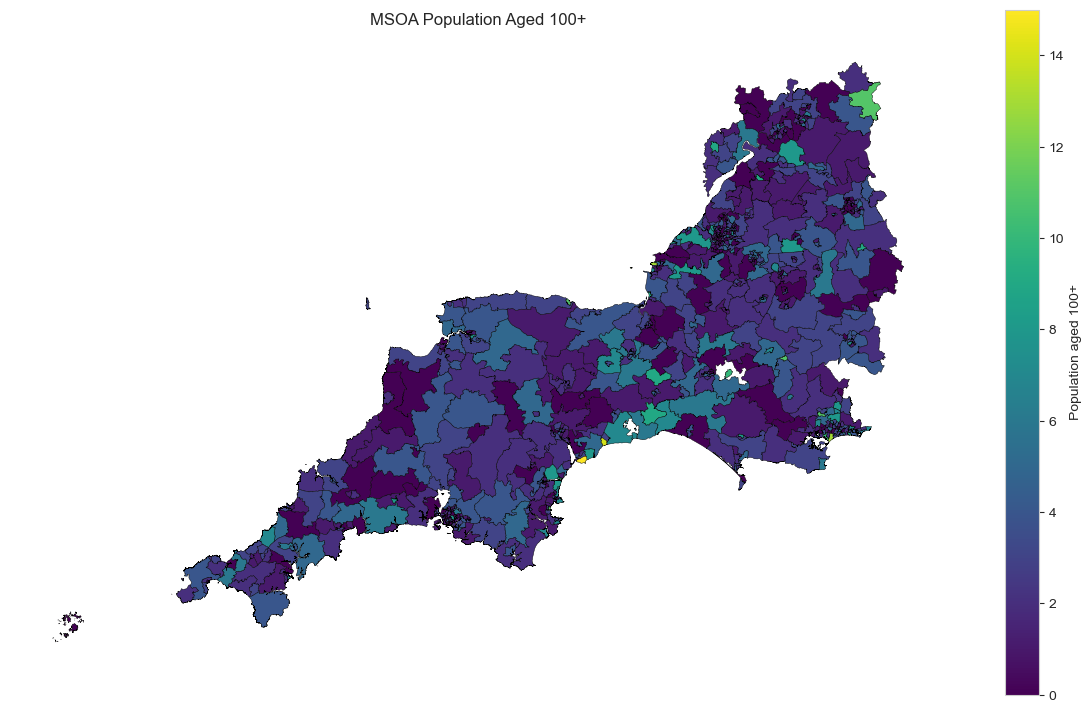

In [26]:
# ------------------------------------------------------------
# Visualize MSOA by population aged 100+
# ------------------------------------------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 14))
gdf_final.plot(
    column='100',         # Age 100+ population column
    cmap='viridis',       # Colour map (adjust as you like)
    legend=True,
    legend_kwds={'label': "Population aged 100+", 'shrink': 0.5},
    ax=ax,
    edgecolor='black',
    linewidth=0.3
)
ax.set_title("MSOA Population Aged 100+")
ax.axis('off')
plt.tight_layout()
plt.show()
